### Overview

In this notebook I want to do exploratory data analysis (EDA) on a dataset that consists information of Alzheimer. The data includes information of healthy and sick people and the goal is to get an idea about features that influence whether someone is sick or not. 

The data is publicly available on https://www.oasis-brains.org.

### Columns definition

- ID: unique ID 
- M/F: Gender (male/female)
- Hand: left or right handed
- Age: Age
- Educ: Education level
- SES: socioeconomic status [more details](https://de.wikipedia.org/wiki/Sozioökonomischer_Status)
- MMSE: Mini-Mental State Examination [more details](https://www.pflege.de/krankheiten/demenz/test/mmst/)
- CDR: Clinical Dementia Rating (CDR; 0= nondemented; 0.5 – very mild dementia; 1 = mild dementia; 2 = moderate dementia)
- eTIV: Estimated total intracranial volume
- nWBV: Normalized whole brain volume 
- ASF: Atlas scaling factor

In [40]:
# import the required packages and libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# set some standard parameter for the visualization
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_color_codes('bright')
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
plt.rcParams["figure.figsize"] = (4, 2.8)
plt.rcParams['figure.dpi'] = 200

In [41]:
# load the data
df = pd.read_csv("../data/oasis_cross-sectional.csv")

In [42]:
# overview of the dataframe
df.head()

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


In [43]:
# convert all columns to lowercase and change 1 column name
df = df.rename(columns=str.lower)
df = df.rename(columns={"m/f":"gender"})

In [44]:
# get an idea for numerical and categorical data
df.nunique()

id        436
gender      2
hand        1
age        73
educ        5
ses         5
mmse       17
cdr         4
etiv      312
nwbv      182
asf       282
delay      14
dtype: int64

In [45]:
# check for null values
df.isnull().sum()

id          0
gender      0
hand        0
age         0
educ      201
ses       220
mmse      201
cdr       201
etiv        0
nwbv        0
asf         0
delay     416
dtype: int64

In [46]:
# due to research in the paper on oasis-brains.org we can fill all missing "cdr" values with 0 as they belong to healthy people
df.cdr = df.cdr.fillna(0)

In [47]:
# get an overview for some statistical values
df.describe()

,age,educ,ses,mmse,cdr,etiv,nwbv,asf,delay
count,436.000000,235.000000,216.000000,235.00000,436.00000,436.000000,436.000000,436.000000,20.00000
mean,51.357798,3.178723,2.490741,27.06383,0.15367,1481.919725,0.791670,1.198894,20.55000
std,25.269862,1.311510,1.120593,3.69687,0.31515,158.740866,0.059937,0.128682,23.86249
min,18.000000,1.000000,1.000000,14.00000,0.00000,1123.000000,0.644000,0.881000,1.00000
25%,23.000000,2.000000,2.000000,26.00000,0.00000,1367.750000,0.742750,1.111750,2.75000
50%,54.000000,3.000000,2.000000,29.00000,0.00000,1475.500000,0.809000,1.190000,11.00000
75%,74.000000,4.000000,3.000000,30.00000,0.00000,1579.250000,0.842000,1.284250,30.75000
max,96.000000,5.000000,5.000000,30.00000,2.00000,1992.000000,0.893000,1.563000,89.00000


In [48]:
def with_hue(ax, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in ax.patches]
    patch = [p for p in ax.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.08
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() + 70
            ax.annotate(percentage, (x, y), size = 12)

### 1. Check overall gender distribution in the dataset

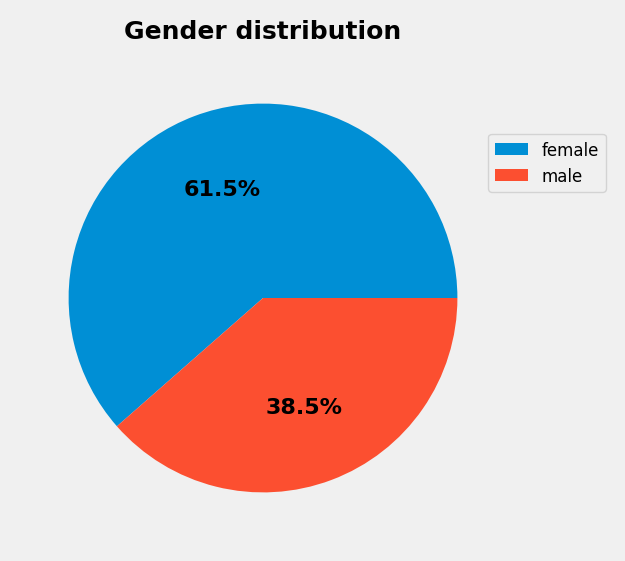

In [49]:
list = [df.gender.value_counts()[0], df.gender.value_counts()[1]]
labels = ["female", "male"]

plt.figure(figsize=(3,3))
ax = plt.pie(list, autopct='%1.1f%%', textprops={"weight" : "bold", "size" : 8})
plt.title("Gender distribution", weight="bold", fontdict={"size" : 9})
plt.legend(ax[0], labels, bbox_to_anchor=(1.1,0.7), loc="center right", fontsize=6, 
           bbox_transform=plt.gcf().transFigure);

The dataset includes 61.5% female person and 38.5% male person

### 1. Check overall handed distribution 

In [50]:
df["hand"].unique()

array(['R'], dtype=object)

There are only right handed people in this dataset.

### 2. Overall Age distribution

First I create some bins in order to visualize more nicely.

In [51]:
# Define bin parameters
bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Use pd.cut to create previously defined bins from "age"
df['binned_age'] = pd.cut(df['age'], bins)

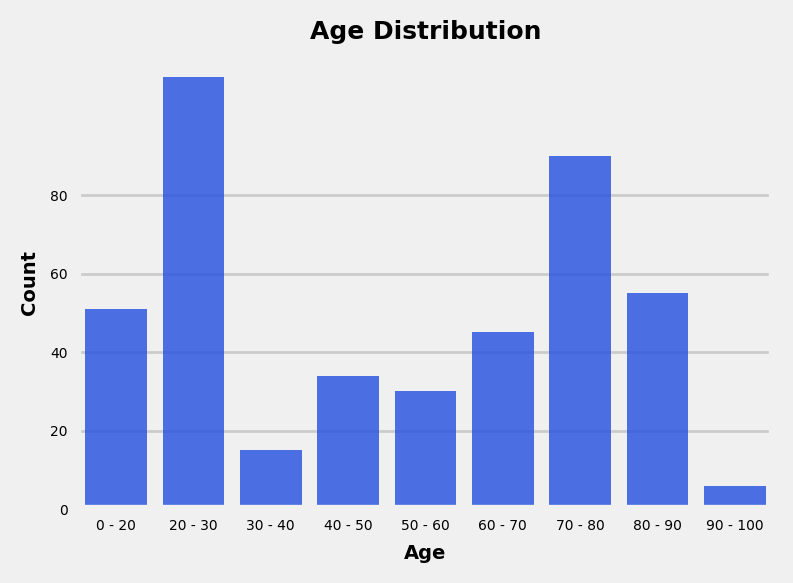

In [52]:
ax = sns.countplot(x=df["binned_age"], color="b", alpha=0.8)

ax.set_title("Age Distribution", weight="bold", fontdict={"size" : 9})
ax.set_xlabel("Age", weight="bold", fontdict={"size" : 7})
ax.set_ylabel("Count", weight="bold", fontdict={"size" : 7})
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
ax.set_yticks([0, 20, 40, 60, 80])
ax.set_xticklabels(["0 - 20", "20 - 30", "30 - 40", "40 - 50", "50 - 60", 
                    "60 - 70", "70 - 80", "80 - 90", "90 - 100"], size = 5)
ax.set_yticklabels(ax.get_yticks(), size = 5);

The minimum age is 18 and besides of that all age classes are represented in our data. For 20 - 30 years and 70 - 80 years we have by far the most observations.

### 3. Overall Education distribution

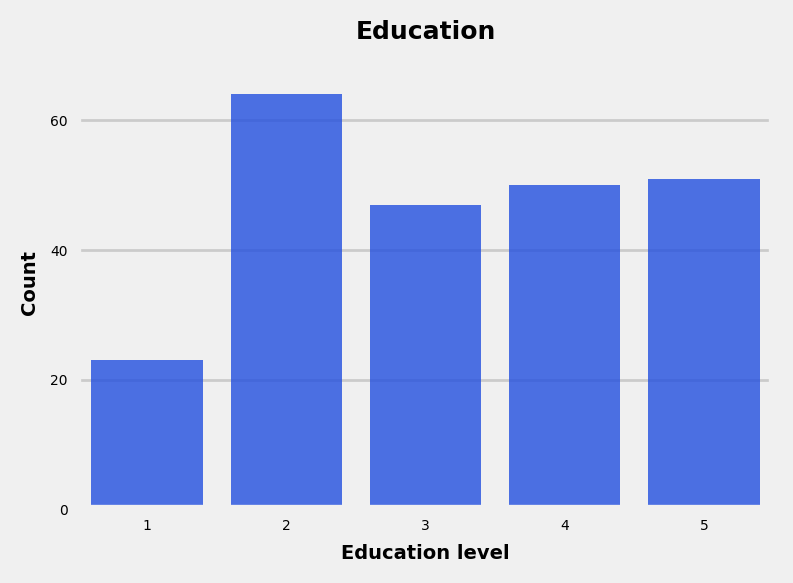

In [53]:
ax2 = sns.countplot(x=df["educ"], color="b", alpha=0.8)

ax2.set_title("Education", weight="bold", fontdict={"size" : 9})
ax2.set_xlabel("Education level", weight="bold", fontdict={"size" : 7})
ax2.set_ylabel("Count", weight="bold", fontdict={"size" : 7})
ax2.set_xticks([0, 1, 2, 3, 4])
ax2.set_yticks([0, 20, 40, 60])
ax2.set_xticklabels(["1", "2", "3", "4", "5"], size = 5)
ax2.set_yticklabels(ax2.get_yticks(), size = 5)

ax2.set_ylim(0, 70);

Except for education level 1 (lowest education) the education is relative evenly distributed.

### 4. Overall SES distribution

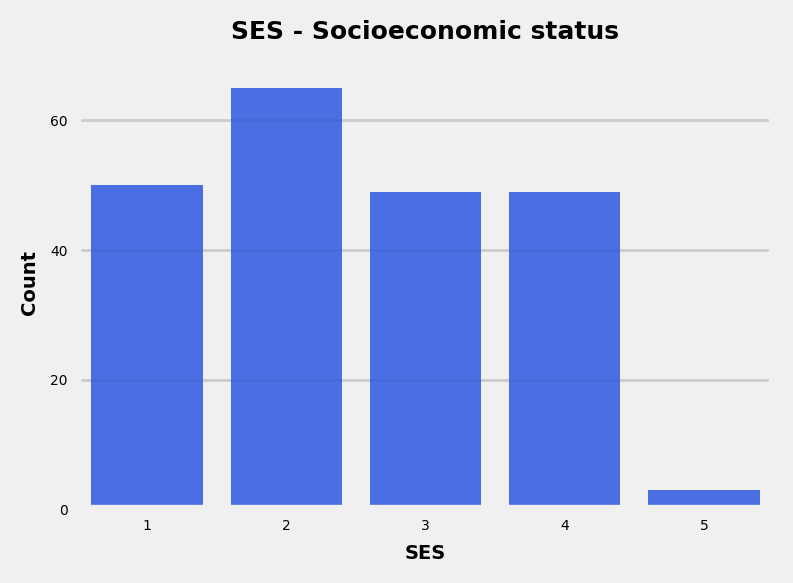

In [54]:
ax3 = sns.countplot(x=df["ses"], color="b", alpha=0.8)

ax3.set_title("SES - Socioeconomic status", weight="bold", fontdict={"size" : 9})
ax3.set_xlabel("SES", weight="bold", fontdict={"size" : 7})
ax3.set_ylabel("Count", weight="bold", fontdict={"size" : 7})
ax3.set_xticks([0, 1, 2, 3, 4])
ax3.set_yticks([0, 20, 40, 60])
ax3.set_xticklabels(["1", "2", "3", "4", "5"], size = 5)
ax3.set_yticklabels(ax3.get_yticks(), size = 5)

ax3.set_ylim(0, 70);

Its pretty similar to education expect that the 5 (most wealthy people) is the outlier. The rest is pretty close together.

### 4. Overall MMSE distribution

Again I create some bins - this time for the MMSE.

In [55]:
# Define bin parameters
bins = [0, 15, 20, 25, 30]

# Use pd.cut to create previously defined bins from "age"
df['binned_mmse'] = pd.cut(df['mmse'], bins)

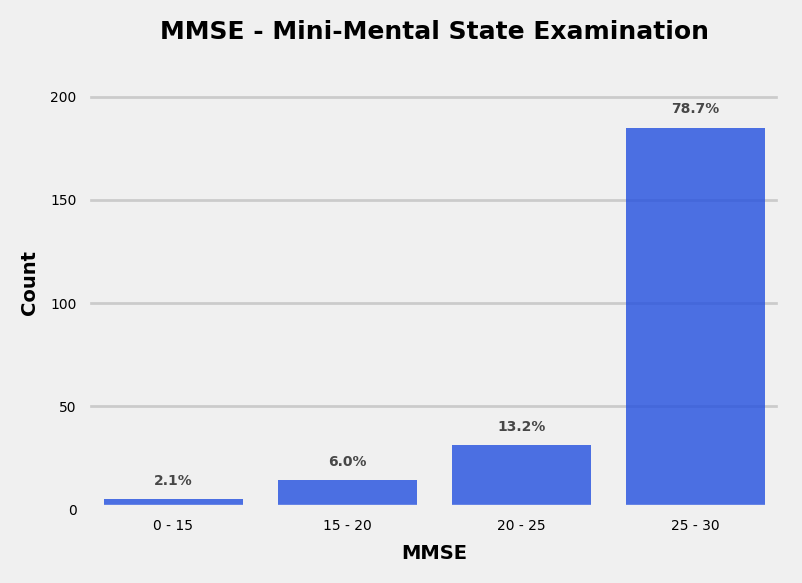

In [56]:
ax4 = sns.countplot(x=df["binned_mmse"], color="b", alpha=0.8)

ax4.set_title("MMSE - Mini-Mental State Examination", weight="bold", fontdict={"size" : 9})
ax4.set_xlabel("MMSE", weight="bold", fontdict={"size" : 7})
ax4.set_ylabel("Count", weight="bold", fontdict={"size" : 7})
ax4.set_xticks([0, 1, 2, 3])
ax4.set_yticks([0, 50, 100, 150, 200])
ax4.set_xticklabels(["0 - 15", "15 - 20", "20 - 25", "25 - 30"], size = 5)
ax4.set_yticklabels(ax4.get_yticks(), size = 5)

total = 235
for p in ax4.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax4.annotate(percentage, (x - 0.4, y + 7), ha = "center", size=5, weight = "bold", alpha = 0.7)

ax4.set_ylim(0, 220);

Its clear that the MMSE is mainly between 25 - 30. Only approx. 20% is distributed between the other 3 bins.

### 4. Overall Dementia distribution

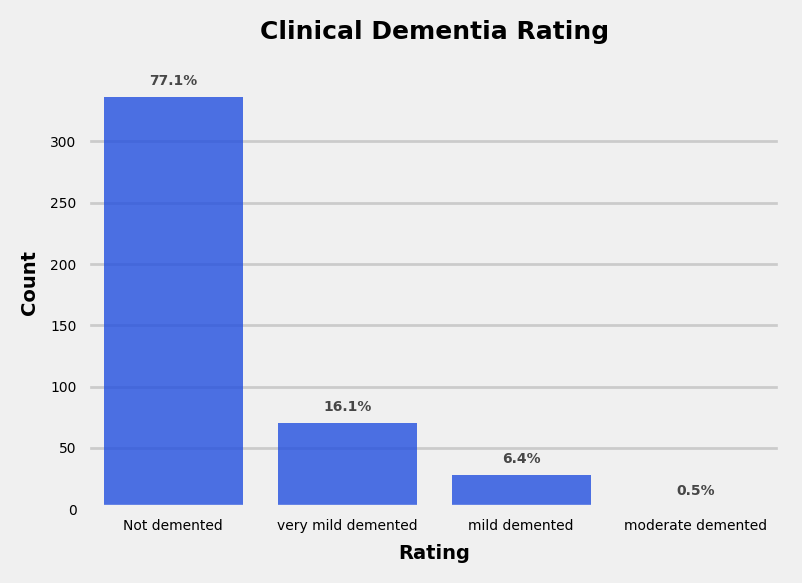

In [57]:
ax5 = sns.countplot(x=df["cdr"], color="b", alpha=0.8)

ax5.set_title("Clinical Dementia Rating", weight="bold", fontdict={"size" : 9})
ax5.set_xlabel("Rating", weight="bold", fontdict={"size" : 7})
ax5.set_ylabel("Count", weight="bold", fontdict={"size" : 7})
ax5.set_xticks([0, 1, 2, 3])
ax5.set_yticks([0, 50, 100, 150, 200, 250, 300])
ax5.set_xticklabels(["Not demented", "very mild demented", "mild demented", "moderate demented"], size = 5)
ax5.set_yticklabels(ax5.get_yticks(), size = 5)

total = float(len(df["cdr"]))
for p in ax5.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax5.annotate(percentage, (x - 0.4, y + 10), ha = "center", size=5, weight = "bold", alpha = 0.7)

ax5.set_ylim(0, 370);

In total we have around 23% sick people in this dataset divided into "very mild demented", "mild demented" and "moderate demented".

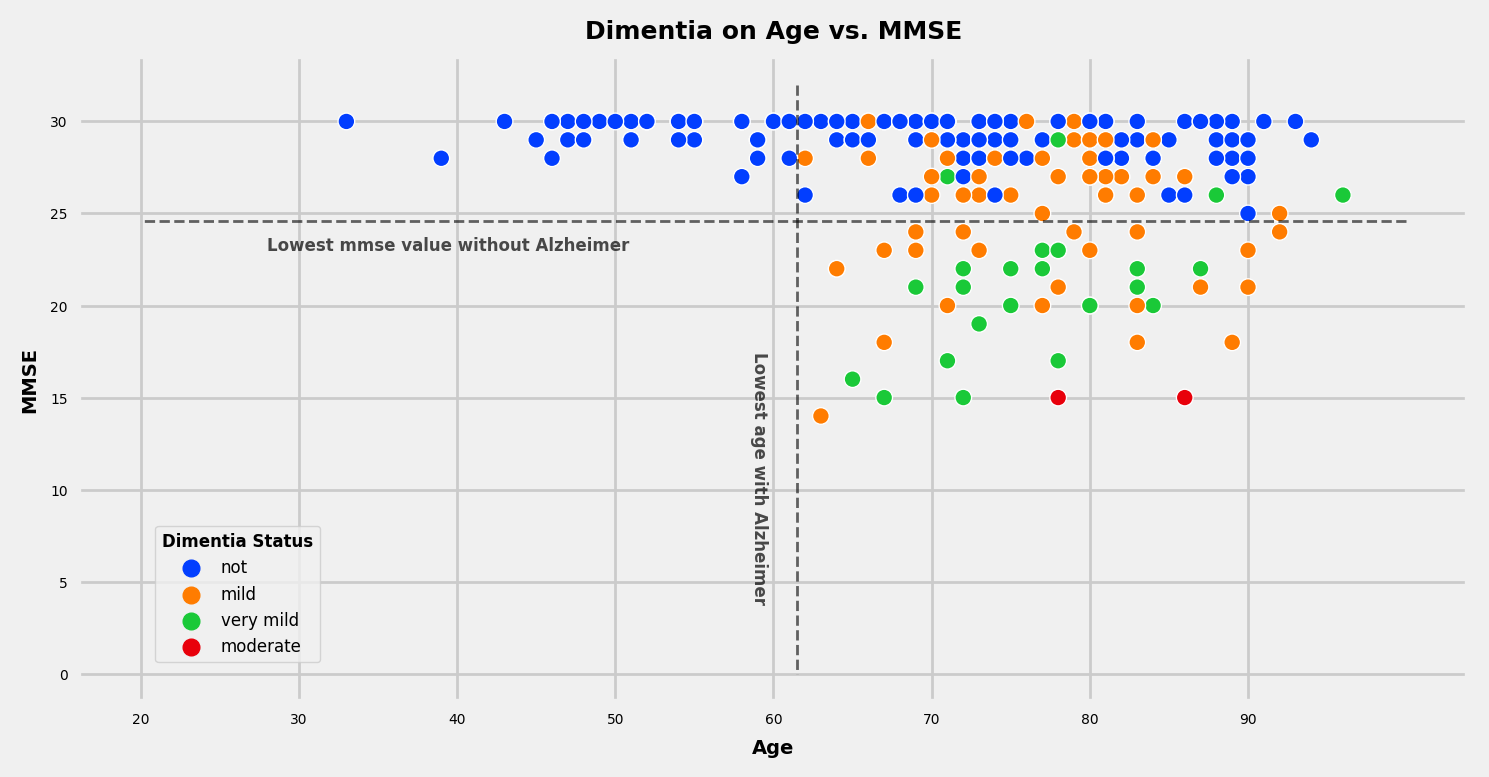

In [58]:
plt.figure(figsize=(8,4))
ax6 = sns.scatterplot(x=df.age, y=df.mmse, hue=df.cdr, palette="bright")
ax6.hlines(24.6, 100, 20, linestyles="--", color="black",linewidth=1, alpha=0.6)
ax6.vlines(61.5, 32, 0, linestyles="--", color="black",linewidth=1, alpha=0.6)
ax6.text(28, 23,"Lowest mmse value without Alzheimer", size=6, alpha=0.7, weight="bold")
ax6.text(58.5, 4, "Lowest age with Alzheimer", size=6, alpha=0.7, weight="bold", rotation=-90)

ax6.set_title("Dimentia on Age vs. MMSE", weight="bold", fontdict={"size" : 9})
ax6.set_xlabel("Age", weight="bold", fontdict={"size" : 7})
ax6.set_ylabel("MMSE", weight="bold", fontdict={"size" : 7})

ax6.set_xticks([20, 30, 40, 50, 60, 70, 80, 90])
ax6.set_yticks([0, 5, 10, 15, 20, 25, 30])
ax6.set_xticklabels(ax6.get_xticks(), size = 5)
ax6.set_yticklabels(ax6.get_yticks(), size = 5)

h,l = ax6.get_legend_handles_labels()
l = [word.replace("0.0","not") for word in l]
l = [word.replace("0.5","mild") for word in l]
l = [word.replace("1.0","very mild") for word in l]
l = [word.replace("2.0","moderate") for word in l]
ax6.legend(h[0:5], l[0:5], title="Dimentia Status", loc="lower left", bbox_to_anchor=(0.05, 0.05), fontsize=6)
plt.setp(ax6.get_legend().get_title(), fontsize="6", weight="bold");

In [59]:
gender_dummies = pd.get_dummies(df.gender)
df_with_gender = pd.concat([df, gender_dummies], axis=1)
gender_group_male = df_with_gender.groupby("cdr")["M"].sum().reset_index()
gender_group_female = df_with_gender.groupby("cdr")["F"].sum().reset_index()
gender_group = pd.merge(gender_group_male, gender_group_female, on="cdr")

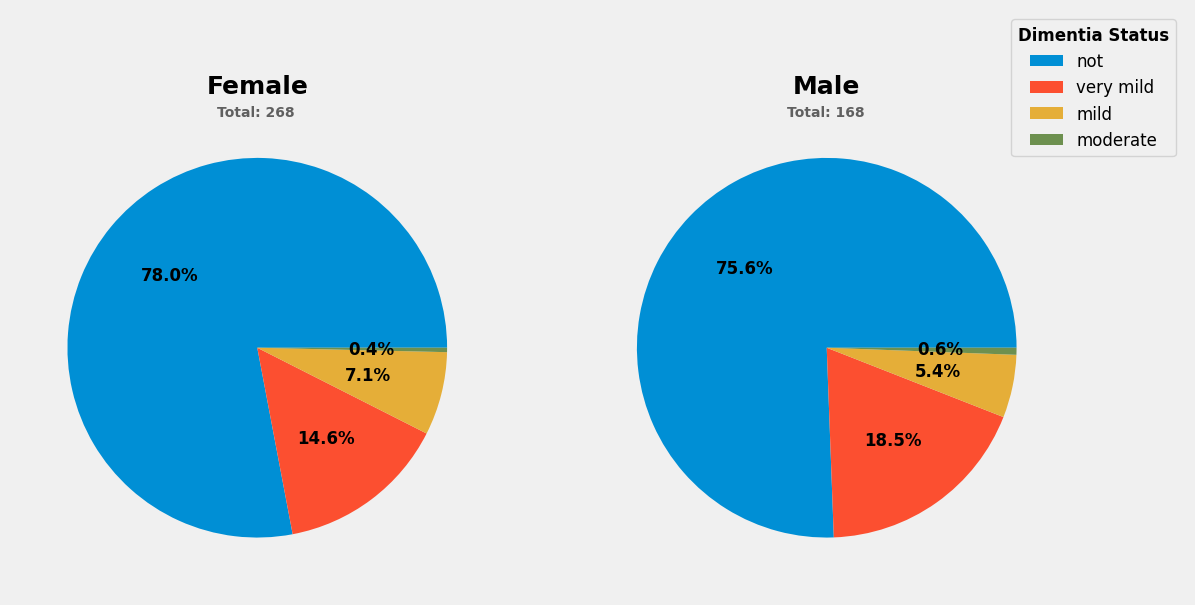

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(6,4))
ax[0].pie(gender_group.F, autopct='%1.1f%%', textprops={"weight" : "bold", "size" : 6})
ax[1].pie(gender_group.M, autopct='%1.1f%%', textprops={"weight" : "bold", "size" : 6})

ax[0].set_title("Female", weight="bold", fontdict={"size" : 9})
ax[1].set_title("Male", weight="bold", fontdict={"size" : 9})

ax[0].legend(title="Dimentia Status", labels=["not", "very mild", "mild", "moderate"], bbox_to_anchor=(1.05,0.8), 
            loc="center right", fontsize=6, bbox_transform=plt.gcf().transFigure)
ax[0].text(-0.21, 1.22, "Total: 268", size=5, alpha=0.6, weight="bold")
ax[1].text(-0.21, 1.22, "Total: 168", size=5, alpha=0.6, weight="bold")

plt.setp(ax[0].get_legend().get_title(), fontsize="6", weight="bold");

In [61]:
educ_dummies = pd.get_dummies(df.educ)
df_with_educ = pd.concat([df, educ_dummies], axis=1)

educ_group_1 = df_with_educ.groupby("cdr")[1.0].sum().reset_index()
educ_group_2 = df_with_educ.groupby("cdr")[2.0].sum().reset_index()
educ_group_3 = df_with_educ.groupby("cdr")[3.0].sum().reset_index()
educ_group_4 = df_with_educ.groupby("cdr")[4.0].sum().reset_index()
educ_group_5 = df_with_educ.groupby("cdr")[5.0].sum().reset_index()

educ_group = pd.merge(pd.merge(pd.merge(pd.merge(educ_group_1, educ_group_2, on='cdr'), 
                      educ_group_3, on='cdr'), educ_group_4, on="cdr"), educ_group_5, on="cdr")

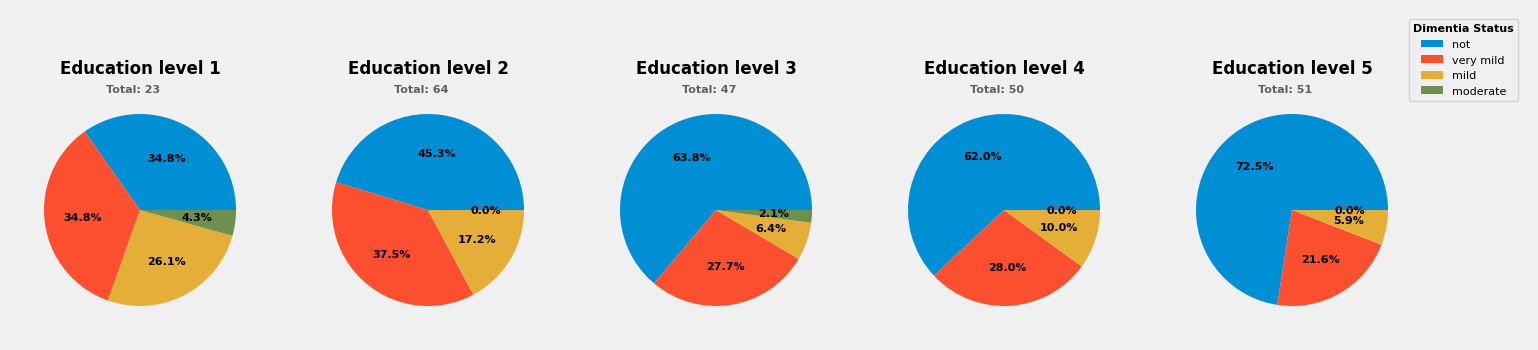

In [62]:
fig, ax = plt.subplots(1, 5, figsize=(8,6))
for i in range(0,5):
    ax[i].pie(educ_group[i + 1], autopct='%1.1f%%', textprops={"weight" : "bold", "size" : 4})
    ax[i].set_title(f"Education level {i + 1}", weight="bold", fontdict={"size" : 6})
    ax[i].text(-0.35, 1.22, f"Total: {educ_group[i + 1].sum()}", size=4, alpha=0.6, weight="bold")


ax[0].legend(title="Dimentia Status", labels=["not", "very mild", "mild", "moderate"], bbox_to_anchor=(1.02,0.6), 
             loc="center right", fontsize=4, bbox_transform=plt.gcf().transFigure)
plt.setp(ax[0].get_legend().get_title(), fontsize="4", weight="bold");

In [63]:
df_above_60 = df.query("age > 60")
df_above_60.head()

,id,gender,hand,age,educ,ses,mmse,cdr,etiv,nwbv,asf,delay,binned_age,binned_mmse
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN,"(70, 80]","(25, 30]"
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN,"(70, 80]","(25, 30]"
8,OAS1_0010_MR1,M,R,74,5.0,2.0,30.0,0.0,1636,0.689,1.073,NaN,"(70, 80]","(25, 30]"
11,OAS1_0013_MR1,F,R,81,5.0,2.0,30.0,0.0,1664,0.679,1.055,NaN,"(80, 90]","(25, 30]"
13,OAS1_0015_MR1,M,R,76,2.0,NaN,28.0,0.5,1738,0.719,1.010,NaN,"(70, 80]","(25, 30]"


In [64]:
df_above_60 = df.query("age > 60")
ses_dummies = pd.get_dummies(df_above_60.ses)
df_with_ses = pd.concat([df, ses_dummies], axis=1)
ses_group_1 = df_with_ses.groupby("cdr")[1.0].sum().reset_index()
ses_group_2 = df_with_ses.groupby("cdr")[2.0].sum().reset_index()
ses_group_3 = df_with_ses.groupby("cdr")[3.0].sum().reset_index()
ses_group_4 = df_with_ses.groupby("cdr")[4.0].sum().reset_index()
ses_group_5 = df_with_ses.groupby("cdr")[5.0].sum().reset_index()

ses_group = pd.merge(pd.merge(pd.merge(pd.merge(ses_group_1, ses_group_2, on="cdr"), 
                     ses_group_3, on="cdr"), ses_group_4, on="cdr"), ses_group_5, on="cdr")

In [71]:
ses_dummies_all = pd.get_dummies(df.ses)
df_with_ses_all = pd.concat([df, ses_dummies_all], axis=1)
ses_group_1_all = df_with_ses_all.groupby("cdr")[1.0].sum().reset_index()
ses_group_2_all = df_with_ses_all.groupby("cdr")[2.0].sum().reset_index()
ses_group_3_all = df_with_ses_all.groupby("cdr")[3.0].sum().reset_index()
ses_group_4_all = df_with_ses_all.groupby("cdr")[4.0].sum().reset_index()
ses_group_5_all = df_with_ses_all.groupby("cdr")[5.0].sum().reset_index()

ses_group_all = pd.merge(pd.merge(pd.merge(pd.merge(ses_group_1_all, ses_group_2_all, on="cdr"), 
                     ses_group_3_all, on="cdr"), ses_group_4_all, on="cdr"), ses_group_5_all, on="cdr")

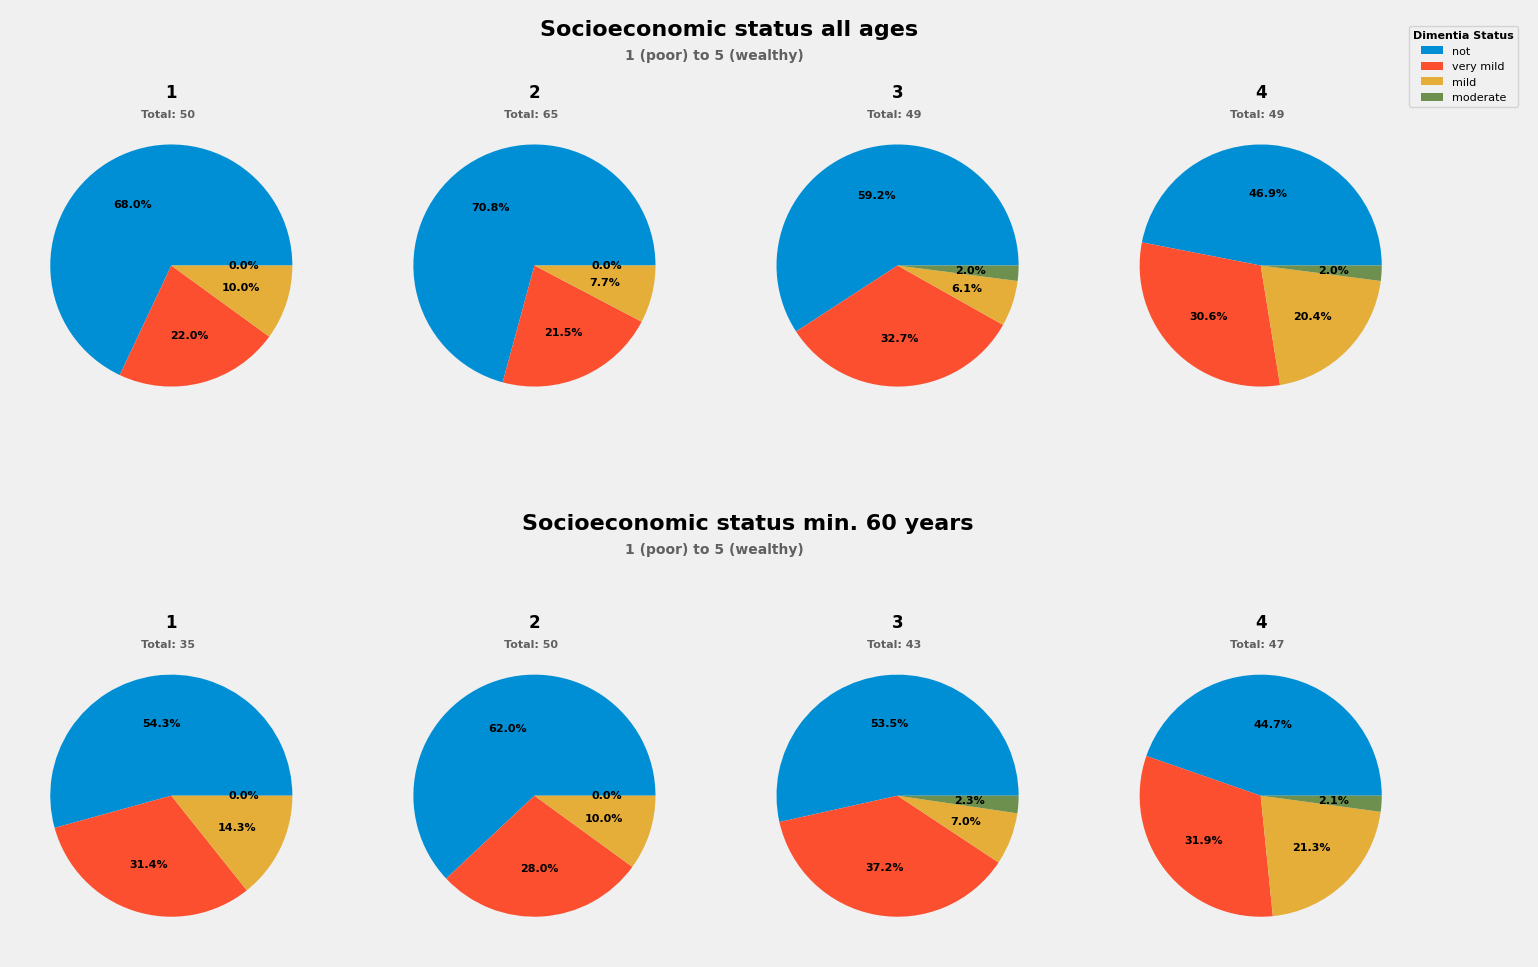

In [105]:
# adjust to only include people older then 60 for example
fig, ax = plt.subplots(2, 4, figsize=(8, 6))
for i in range(0, 4):
    ax[0, i].pie(ses_group_all[i + 1], autopct='%1.1f%%', textprops={"weight" : "bold", "size" : 4})
    ax[0, i].set_title(f"{i + 1}", weight="bold", fontdict={"size" : 6})
    ax[0, i].text(-0.25, 1.22, f"Total: {ses_group_all[i + 1].sum()}", size=4, alpha=0.6, weight="bold")
    ax[1, i].pie(ses_group[i + 1], autopct='%1.1f%%', textprops={"weight" : "bold", "size" : 4})
    ax[1, i].set_title(f"{i + 1}", weight="bold", fontdict={"size" : 6})
    ax[1, i].text(-0.25, 1.22, f"Total: {int(ses_group[i + 1].sum())}", size=4, alpha=0.6, weight="bold")

ax[0, 1].text(0.05, 1.9, "Socioeconomic status all ages", size=8, weight="bold")
ax[1, 1].text(-0.1, 2.2, "Socioeconomic status min. 60 years", size=8, weight="bold")
ax[0, 1].text(0.75, 1.7, "1 (poor) to 5 (wealthy)", alpha=0.6, size=5, weight="bold")
ax[1, 1].text(0.75, 2.0, "1 (poor) to 5 (wealthy)", alpha=0.6, size=5, weight="bold")
ax[0, 1].legend(title="Dimentia Status", labels=["not", "very mild", "mild", "moderate"], bbox_to_anchor=(1.02,0.9), 
             loc="upper right", fontsize=4, bbox_transform=plt.gcf().transFigure)
plt.setp(ax[0, 1].get_legend().get_title(), fontsize="4", weight="bold");

### Check etiv / nwbv ratio. Expected: ratio should shrink with higher dementia rating. 

In [106]:
df.head()

,id,gender,hand,age,educ,ses,mmse,cdr,etiv,nwbv,asf,delay,binned_age,binned_mmse
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN,"(70, 80]","(25.0, 30.0]"
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN,"(50, 60]","(25.0, 30.0]"
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN,"(70, 80]","(25.0, 30.0]"
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,0.0,1588,0.803,1.105,NaN,"(20, 30]",NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,0.0,1737,0.848,1.010,NaN,"(0, 20]",NaN


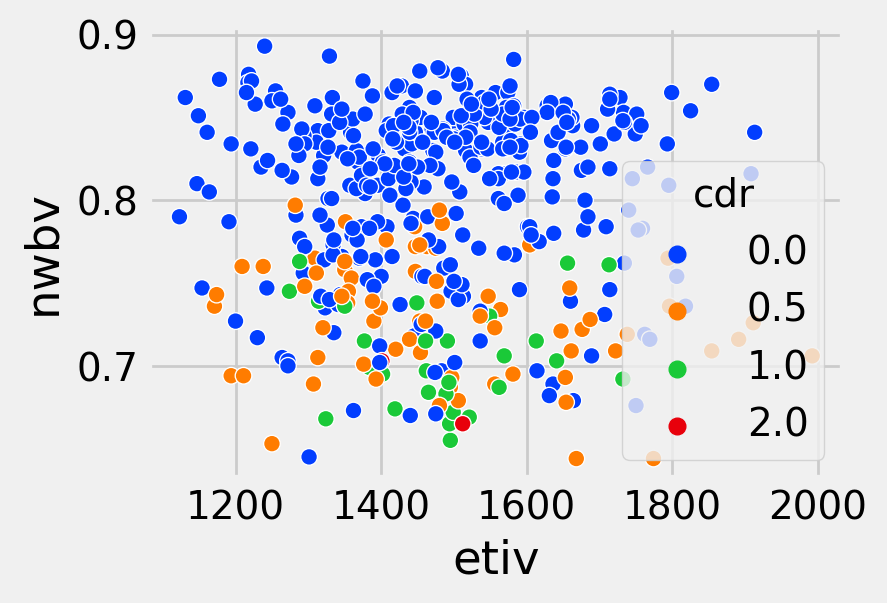

In [108]:
ax6 = sns.scatterplot(x=df.etiv, y=df.nwbv, hue=df.cdr, palette="bright")

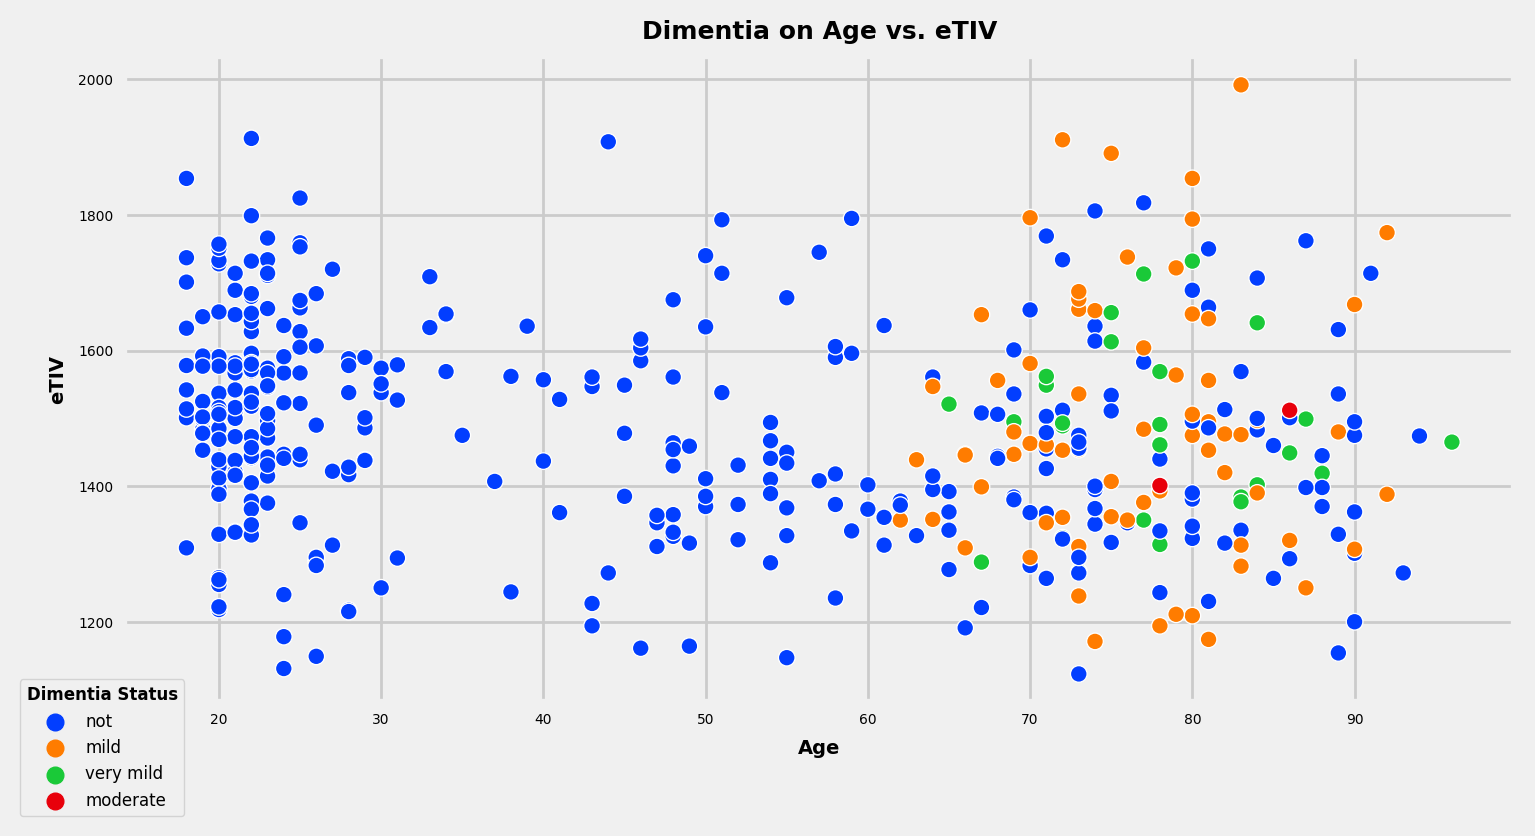

In [67]:
plt.figure(figsize=(8,4))
ax6 = sns.scatterplot(x=df.age, y=df.etiv, hue=df.cdr, palette="bright")

ax6.set_title("Dimentia on Age vs. eTIV", weight="bold", fontdict={"size" : 9})
ax6.set_xlabel("Age", weight="bold", fontdict={"size" : 7})
ax6.set_ylabel("eTIV", weight="bold", fontdict={"size" : 7})
ax6.set_xticks([20, 30, 40, 50, 60, 70, 80, 90])
ax6.set_yticks([1200, 1400, 1600, 1800, 2000])
ax6.set_xticklabels(ax6.get_xticks(), size = 5)
ax6.set_yticklabels(ax6.get_yticks(), size = 5)

h,l = ax6.get_legend_handles_labels()
l = [word.replace("0.0","not") for word in l]
l = [word.replace("0.5","mild") for word in l]
l = [word.replace("1.0","very mild") for word in l]
l = [word.replace("2.0","moderate") for word in l]
ax6.legend(h[0:5], l[0:5], title="Dimentia Status", loc="upper right", bbox_to_anchor=(0.05, 0.05), fontsize=6)
plt.setp(ax6.get_legend().get_title(), fontsize="6", weight="bold");

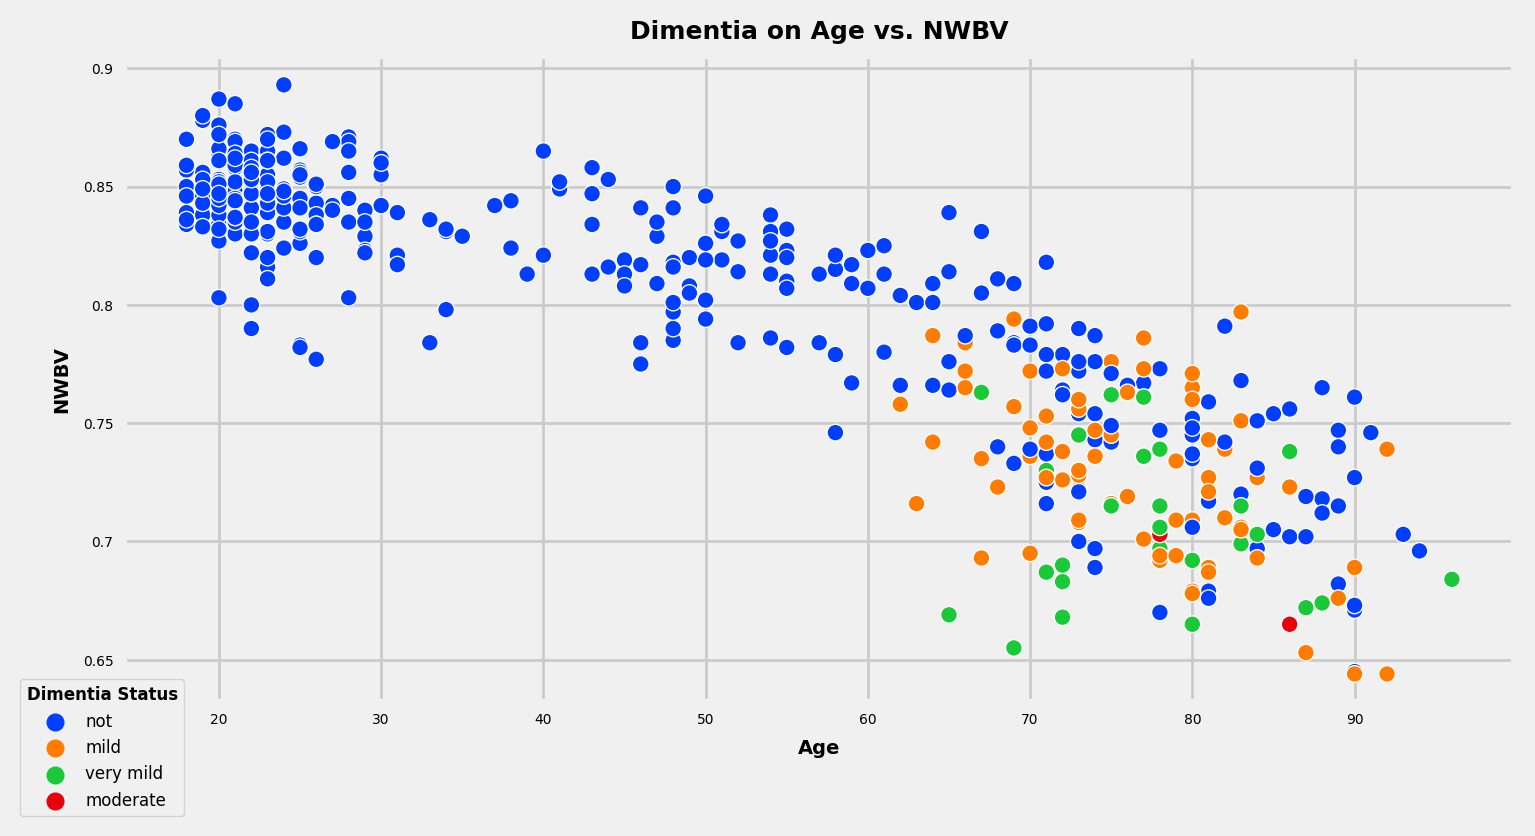

In [68]:
plt.figure(figsize=(8,4))
ax6 = sns.scatterplot(x=df.age, y=df.nwbv, hue=df.cdr, palette="bright")

ax6.set_title("Dimentia on Age vs. NWBV", weight="bold", fontdict={"size" : 9})
ax6.set_xlabel("Age", weight="bold", fontdict={"size" : 7})
ax6.set_ylabel("NWBV", weight="bold", fontdict={"size" : 7})

ax6.set_xticks([20, 30, 40, 50, 60, 70, 80, 90])
ax6.set_yticks([0.65, 0.70, 0.75, 0.80, 0.85, 0.90])
ax6.set_xticklabels(ax6.get_xticks(), size = 5)
ax6.set_yticklabels(ax6.get_yticks(), size = 5)

h,l = ax6.get_legend_handles_labels()
l = [word.replace("0.0","not") for word in l]
l = [word.replace("0.5","mild") for word in l]
l = [word.replace("1.0","very mild") for word in l]
l = [word.replace("2.0","moderate") for word in l]
ax6.legend(h[0:5], l[0:5], title="Dimentia Status", loc="upper right", bbox_to_anchor=(0.05, 0.05), fontsize=6)
plt.setp(ax6.get_legend().get_title(), fontsize="6", weight="bold");

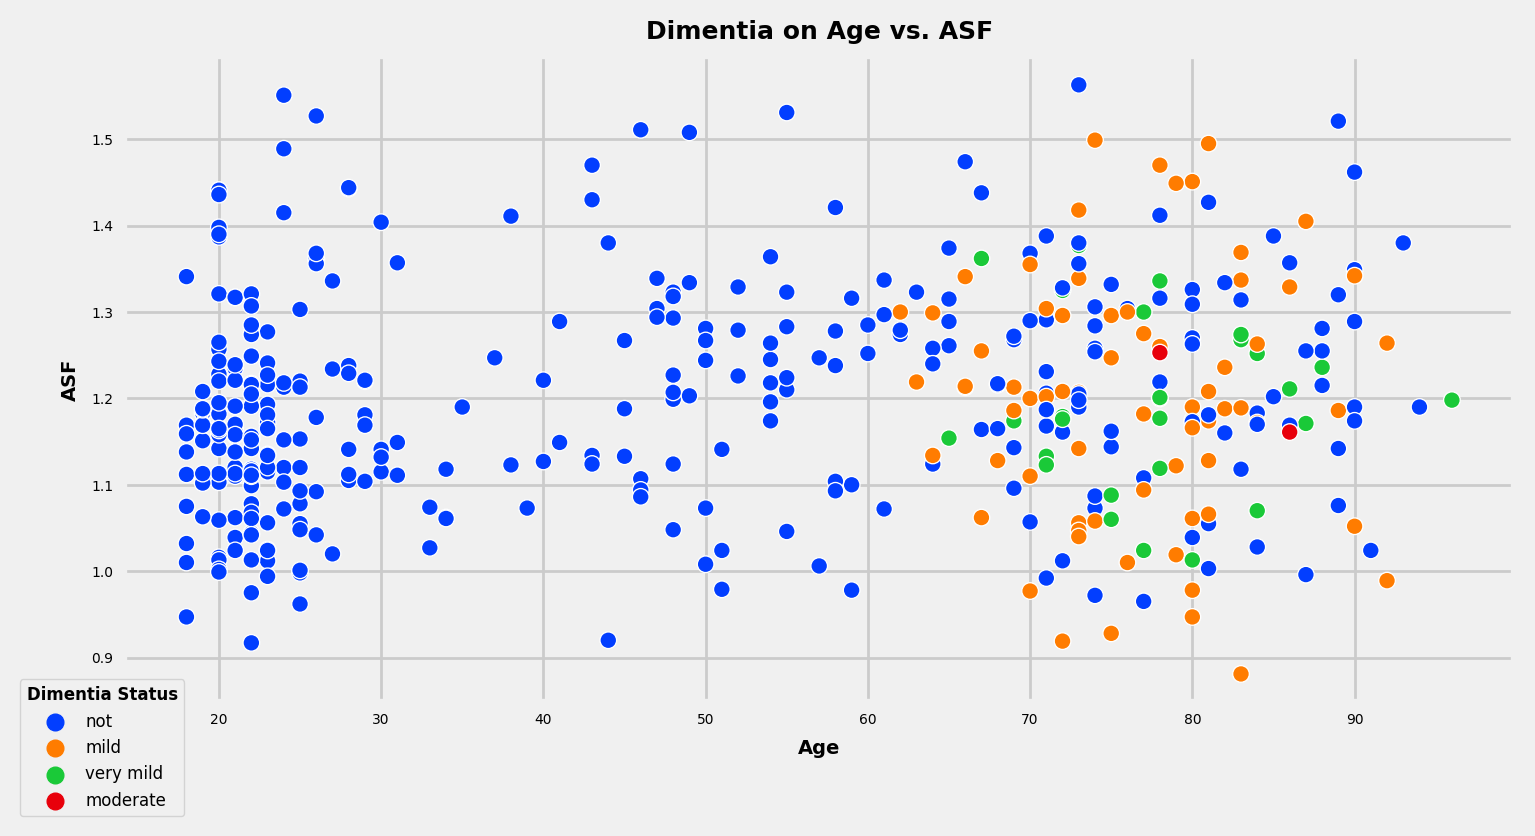

In [69]:
plt.figure(figsize=(8,4))
ax6 = sns.scatterplot(x=df.age, y=df.asf, hue=df.cdr, palette="bright")

ax6.set_title("Dimentia on Age vs. ASF", weight="bold", fontdict={"size" : 9})
ax6.set_xlabel("Age", weight="bold", fontdict={"size" : 7})
ax6.set_ylabel("ASF", weight="bold", fontdict={"size" : 7})

ax6.set_xticks([20, 30, 40, 50, 60, 70, 80, 90])
ax6.set_yticks([0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5])
ax6.set_xticklabels(ax6.get_xticks(), size = 5)
ax6.set_yticklabels(ax6.get_yticks(), size = 5)

h,l = ax6.get_legend_handles_labels()
l = [word.replace("0.0","not") for word in l]
l = [word.replace("0.5","mild") for word in l]
l = [word.replace("1.0","very mild") for word in l]
l = [word.replace("2.0","moderate") for word in l]
ax6.legend(h[0:5], l[0:5], title="Dimentia Status", loc="upper right", bbox_to_anchor=(0.05, 0.05), fontsize=6)
plt.setp(ax6.get_legend().get_title(), fontsize="6", weight="bold");

In [70]:
df.head()

,id,gender,hand,age,educ,ses,mmse,cdr,etiv,nwbv,asf,delay,binned_age,binned_mmse
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN,"(70, 80]","(25.0, 30.0]"
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN,"(50, 60]","(25.0, 30.0]"
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN,"(70, 80]","(25.0, 30.0]"
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,0.0,1588,0.803,1.105,NaN,"(20, 30]",NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,0.0,1737,0.848,1.010,NaN,"(0, 20]",NaN
